In [1]:
!python -V

Python 3.12.0


In [2]:
# Imported libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os
from dataclasses import dataclass, field
from typing import Optional, List
import pickle

# ML libraries
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
# Import MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")

mlflow.set_experiment("prediction_tracking")

<Experiment: artifact_location=('file:///c:/Users/CamiloA/OneDrive/Documents/Python '
 'Scripts/mlops_2024/02_experiment_tracking/mlruns/2'), creation_time=1716641954616, experiment_id='2', last_update_time=1716641954616, lifecycle_stage='active', name='prediction_tracking', tags={}>

In [4]:
@dataclass
class DataLoader(object):
    folder_name: str
    filename: str
    final_path: Optional[str] = field(init=False, repr=False)

    def __post_init__(self):
        self.final_path = os.path.join(self.folder_name, self.filename)
    
    def load_data(self) -> None:
        if self.filename.endswith(".csv"):
            dataframe_loaded = pd.read_csv(self.final_path)
            lowercase = lambda x: str(x).lower()
            dataframe_loaded.rename(lowercase, axis='columns', inplace=True)
            
            # Convert the time columns to the appropriate datetime format.
            dataframe_loaded['tpep_pickup_datetime'] = pd.to_datetime(dataframe_loaded['tpep_pickup_datetime'])
            dataframe_loaded['tpep_dropoff_datetime'] = pd.to_datetime(dataframe_loaded['tpep_dropoff_datetime'])
            print(f"The original dataframe has this number of columns: {dataframe_loaded.shape[1]} and rows: {dataframe_loaded.shape[0]}")
            
        elif self.filename.endswith(".parquet"):
            dataframe_loaded = pd.read_parquet(self.final_path)
            lowercase = lambda x: str(x).lower()
            dataframe_loaded.rename(lowercase, axis='columns', inplace=True)
            print(f"The original dataframe has this number of columns: {dataframe_loaded.shape[1]} and rows: {dataframe_loaded.shape[0]}")
            
        dataframe_loaded['trip_duration'] =  ((dataframe_loaded['tpep_dropoff_datetime'] - dataframe_loaded['tpep_pickup_datetime']).dt.total_seconds()) / 60  
        
            
        return dataframe_loaded
    
    def data_cleaning_manipulation(self, dataframe_loaded, durationcolumn: str, min_duration: int, max_duration: int):
        standard_deviation_calc = np.std(dataframe_loaded[durationcolumn])
        print(f"The standard deviation of the calculated trip duration is: {standard_deviation_calc}")
        
        # Plot the histogram of the trip duration
        sns.histplot(dataframe_loaded[durationcolumn])
        plt.xlabel('Trip Duration (minutes)')
        plt.ylabel('Frequency')
        plt.title('Trip Duration Distribution')
        plt.show()
        
        # Filter the DataFrame based on the trip duration range
        dataframe_cleaned = dataframe_loaded[(dataframe_loaded[durationcolumn] >= min_duration) & (dataframe_loaded[durationcolumn] <= max_duration)]
        print(f"Filtered dataframe has this number of columns: {dataframe_cleaned.shape[1]} and rows: {dataframe_cleaned.shape[0]}")
        
        percentage_remaining = (dataframe_cleaned.shape[0] / dataframe_loaded.shape[0]) * 100
        print(f"Percentage of data remaining after filtering: {percentage_remaining:.2f}%")
        
        return dataframe_cleaned     

In [25]:
@dataclass
class ModelTraining:
    categorical: List[str]
    numerical: List[str]
    target_column: str
    training_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    validation_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    dv: DictVectorizer = field(default=None, init=False)
    
    
    def one_hot_encoder_training(self):
        self.training_data[self.categorical] = self.training_data[self.categorical].astype(str)
        print(self.training_data[self.categorical].dtypes)
        train_dicts = self.training_data[self.categorical + self.numerical].to_dict(orient = "records")
        #* Target training
        y_train = self.training_data[self.target_column].values
        
        
        # Applying a one hot encoder to the categorical variables.
        dv = DictVectorizer()
        X_train = dv.fit_transform(train_dicts)
        # Calculate the dimensionality of the feature matrix
        num_features = X_train.shape[1]
        print(f"Dimensionality of the feature matrix: {num_features} columns")
        
        self.dv = dv
        return X_train, y_train, dv
    
    
    def one_hot_encoder_validation(self):
        self.validation_data[self.categorical] = self.validation_data[self.categorical].astype(str)
        print(self.validation_data[self.categorical].dtypes)
        val_dicts = self.validation_data[self.categorical + self.numerical].to_dict(orient = "records")
        #* Target training
        y_val = self.validation_data[self.target_column].values
        
        # Applying a one hot encoder to the categorical variables.
        X_val = self.dv.transform(val_dicts)
        # Calculate the dimensionality of the feature matrix
        num_features = X_val.shape[1]
        print(f"Dimensionality of the feature matrix: {num_features} columns")
        
        return X_val, y_val
    
    
    def model_train(self, X_train, y_train, X_val, y_val):
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        
        y_pred = lr.predict(X_train)
        mse_calculated = mean_squared_error(y_train, y_pred, squared=False)
        print(f"The Mean Squared Error is: {mse_calculated}")
        
        # Plot the Precition
        sns.histplot(y_pred, label='Prediction')
        sns.histplot(y_train, label="Actual")
        plt.legend()
        
        y_pred_val = lr.predict(X_val)
        mse_calculated_val = mean_squared_error(y_val, y_pred_val, squared=False)
        print(f"The Mean Squared Error Validation is: {mse_calculated_val}")

In [6]:
data_loader_january = DataLoader(folder_name="..\\data", 
                                 filename='yellow_tripdata_2023-01.parquet')
yellow_data_january = data_loader_january.load_data()
yellow_data_january.head()

The original dataframe has this number of columns: 19 and rows: 3066766


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


The standard deviation of the calculated trip duration is: 42.59434429744777


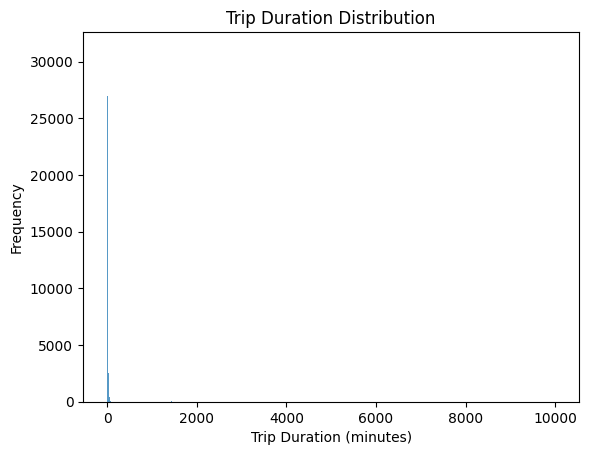

Filtered dataframe has this number of columns: 20 and rows: 3009173
Percentage of data remaining after filtering: 98.12%


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [7]:
yellow_data_january_cleaned = data_loader_january.data_cleaning_manipulation(dataframe_loaded=yellow_data_january, 
                                                                             durationcolumn="trip_duration", 
                                                                             min_duration=1, max_duration=60)
yellow_data_january_cleaned.head()

In [8]:
data_loader_february = DataLoader(folder_name="..\\data", 
                                  filename='yellow_tripdata_2023-02.parquet')
yellow_data_february = data_loader_february.load_data()
yellow_data_february.head()

The original dataframe has this number of columns: 19 and rows: 2913955


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00,1.683333
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00,0.233333
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00,0.233333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00,13.300000


The standard deviation of the calculated trip duration is: 42.84209440985569


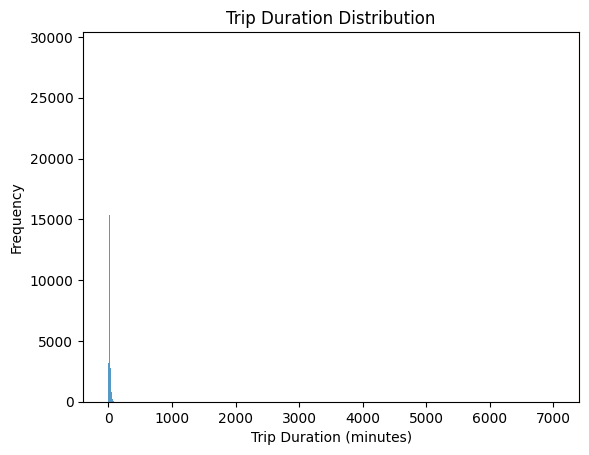

Filtered dataframe has this number of columns: 20 and rows: 2855951
Percentage of data remaining after filtering: 98.01%


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [9]:
yellow_data_february_cleaned = data_loader_february.data_cleaning_manipulation(dataframe_loaded=yellow_data_february, 
                                                                               durationcolumn="trip_duration", 
                                                                               min_duration=1, 
                                                                               max_duration=60)
yellow_data_february_cleaned.head()

C:\Users\CamiloA\AppData\Local\Temp\ipykernel_27960\2781858167.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.training_data[self.categorical] = self.training_data[self.categorical].astype(str)


pulocationid    object
dolocationid    object
dtype: object
Dimensionality of the feature matrix: 516 columns


C:\Users\CamiloA\AppData\Local\Temp\ipykernel_27960\2781858167.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.validation_data[self.categorical] = self.validation_data[self.categorical].astype(str)


pulocationid    object
dolocationid    object
dtype: object
Dimensionality of the feature matrix: 516 columns


c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Mean Squared Error is: 7.658559076531841


c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Mean Squared Error Validation is: 7.820057137415617


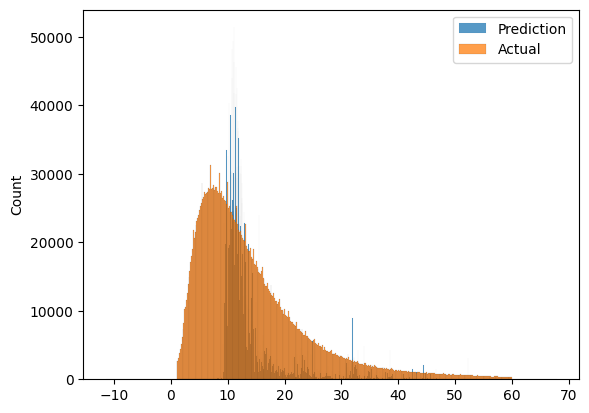

In [27]:
model_train = ModelTraining(categorical=['pulocationid', 'dolocationid'],
                            numerical=['trip_distance'],
                            target_column="trip_duration",
                            training_data=yellow_data_january_cleaned,
                            validation_data=yellow_data_february_cleaned)

X_train, y_train, dv = model_train.one_hot_encoder_training()
X_val, y_val = model_train.one_hot_encoder_validation()

model_train.model_train(X_train=X_train,
                        y_train=y_train,
                        X_val=X_val,
                        y_val=y_val)

In [11]:
### Using mlflow

with mlflow.start_run():
    
    mlflow.set_tag("demo", "Lasso")
    
    mlflow.log_param("train-data-path", "..\\data\\yellow_tripdata_2023-01.parquet") 
    mlflow.log_param("valid-data-path", "..\\data\\yellow_tripdata_2023-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)


c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [14]:
'''
    The objective function will require the parameters for the especific run but passed on mlflow to keep 
    track. The parameters are scpecific for xgboost and linked to that run. 
    They will be log to the run and passed to the model to generate the boosted object on the training data. 
    
    The validation set will used to control the optimization algorithm of xgboost, it will try tom minimize the 
    error by the number of iterations.
    
    Finally, the test will be calculated on the val and obtaining the error. 

'''
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [15]:
'''
    Search Space: Are the ranges in were hyperopt will search for hyperparameters. 
        The hyperparameters have to be defined based on the type of model ...
        
'''
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.81239                           
[1]	validation-rmse:4.63761                           
[2]	validation-rmse:4.61915                           
[3]	validation-rmse:4.61218                           
[4]	validation-rmse:4.60967                           
[5]	validation-rmse:4.60306                           
[6]	validation-rmse:4.59947                           
[7]	validation-rmse:4.59278                           
[8]	validation-rmse:4.58559                           
[9]	validation-rmse:4.58574                           
[10]	validation-rmse:4.58456                          
[11]	validation-rmse:4.58479                          
[12]	validation-rmse:4.58419                          
[13]	validation-rmse:4.58384                          
[14]	validation-rmse:4.58349                          
[15]	validation-rmse:4.58358                          
[16]	validation-rmse:4.58354                          
[17]	validation-rmse:4.58290                          
[18]	valid

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.24724                                                     
[1]	validation-rmse:8.54041                                                     
[2]	validation-rmse:7.93427                                                     
[3]	validation-rmse:7.41762                                                     
[4]	validation-rmse:6.97960                                                     
[5]	validation-rmse:6.60930                                                     
[6]	validation-rmse:6.29876                                                     
[7]	validation-rmse:6.03913                                                     
[8]	validation-rmse:5.82235                                                     
[9]	validation-rmse:5.64170                                                     
[10]	validation-rmse:5.49239                                                    
[11]	validation-rmse:5.36996                                                    
[12]	validation-rmse:5.26812

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61025                                                        
[1]	validation-rmse:7.49504                                                        
[2]	validation-rmse:6.66723                                                        
[3]	validation-rmse:6.05461                                                        
[4]	validation-rmse:5.61664                                                        
[5]	validation-rmse:5.30677                                                        
[6]	validation-rmse:5.08587                                                        
[7]	validation-rmse:4.93580                                                        
[8]	validation-rmse:4.82857                                                        
[9]	validation-rmse:4.75676                                                        
[10]	validation-rmse:4.70464                                                       
[11]	validation-rmse:4.66854                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.54786                                                        
[1]	validation-rmse:9.07319                                                        
[2]	validation-rmse:8.63924                                                        
[3]	validation-rmse:8.24321                                                        
[4]	validation-rmse:7.88306                                                        
[5]	validation-rmse:7.55614                                                        
[6]	validation-rmse:7.25860                                                        
[7]	validation-rmse:6.99052                                                        
[8]	validation-rmse:6.74786                                                        
[9]	validation-rmse:6.52997                                                        
[10]	validation-rmse:6.33415                                                       
[11]	validation-rmse:6.15696                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.27956                                                        
[1]	validation-rmse:8.59443                                                        
[2]	validation-rmse:7.99990                                                        
[3]	validation-rmse:7.48457                                                        
[4]	validation-rmse:7.04338                                                        
[5]	validation-rmse:6.66577                                                        
[6]	validation-rmse:6.34217                                                        
[7]	validation-rmse:6.06953                                                        
[8]	validation-rmse:5.83980                                                        
[9]	validation-rmse:5.64380                                                        
[10]	validation-rmse:5.48185                                                       
[11]	validation-rmse:5.34583                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.58733                                                        
[1]	validation-rmse:9.14121                                                        
[2]	validation-rmse:8.73151                                                        
[3]	validation-rmse:8.35198                                                        
[4]	validation-rmse:8.00443                                                        
[5]	validation-rmse:7.68310                                                        
[6]	validation-rmse:7.39026                                                        
[7]	validation-rmse:7.11991                                                        
[8]	validation-rmse:6.87291                                                        
[9]	validation-rmse:6.64942                                                        
[10]	validation-rmse:6.44399                                                       
[11]	validation-rmse:6.25756                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.52527                                                        
[1]	validation-rmse:9.03218                                                        
[2]	validation-rmse:8.58360                                                        
[3]	validation-rmse:8.17635                                                        
[4]	validation-rmse:7.80793                                                        
[5]	validation-rmse:7.47516                                                        
[6]	validation-rmse:7.17414                                                        
[7]	validation-rmse:6.90443                                                        
[8]	validation-rmse:6.66139                                                        
[9]	validation-rmse:6.44448                                                        
[10]	validation-rmse:6.25054                                                       
[11]	validation-rmse:6.07770                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:57:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.67192                                                        
[1]	validation-rmse:9.29909                                                        
[2]	validation-rmse:8.95156                                                        
[3]	validation-rmse:8.62445                                                        
[4]	validation-rmse:8.31870                                                        
[5]	validation-rmse:8.03470                                                        
[6]	validation-rmse:7.76815                                                        
[7]	validation-rmse:7.52140                                                        
[8]	validation-rmse:7.28965                                                        
[9]	validation-rmse:7.07505                                                        
[10]	validation-rmse:6.87673                                                       
[11]	validation-rmse:6.69083                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84022                                                        
[1]	validation-rmse:7.87180                                                        
[2]	validation-rmse:7.11765                                                        
[3]	validation-rmse:6.53522                                                        
[4]	validation-rmse:6.09526                                                        
[5]	validation-rmse:5.76119                                                        
[6]	validation-rmse:5.51338                                                        
[7]	validation-rmse:5.32811                                                        
[8]	validation-rmse:5.19114                                                        
[9]	validation-rmse:5.08961                                                        
[10]	validation-rmse:5.01088                                                       
[11]	validation-rmse:4.95313                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.29118                                                        
[1]	validation-rmse:4.76941                                                        
[2]	validation-rmse:4.69933                                                        
[3]	validation-rmse:4.67362                                                        
[4]	validation-rmse:4.66688                                                        
[5]	validation-rmse:4.65668                                                        
[6]	validation-rmse:4.63626                                                        
[7]	validation-rmse:4.63019                                                        
[8]	validation-rmse:4.62321                                                        
[9]	validation-rmse:4.61785                                                        
[10]	validation-rmse:4.60743                                                       
[11]	validation-rmse:4.60043                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.57253                                                         
[1]	validation-rmse:9.11658                                                         
[2]	validation-rmse:8.69523                                                         
[3]	validation-rmse:8.30983                                                         
[4]	validation-rmse:7.95456                                                         
[5]	validation-rmse:7.62897                                                         
[6]	validation-rmse:7.33318                                                         
[7]	validation-rmse:7.06144                                                         
[8]	validation-rmse:6.81404                                                         
[9]	validation-rmse:6.59063                                                         
[10]	validation-rmse:6.38706                                                        
[11]	validation-rmse:6.20309                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.64096                                                         
[1]	validation-rmse:9.24500                                                         
[2]	validation-rmse:8.87806                                                         
[3]	validation-rmse:8.53847                                                         
[4]	validation-rmse:8.22485                                                         
[5]	validation-rmse:7.93544                                                         
[6]	validation-rmse:7.66838                                                         
[7]	validation-rmse:7.42286                                                         
[8]	validation-rmse:7.19714                                                         
[9]	validation-rmse:6.99022                                                         
[10]	validation-rmse:6.80024                                                        
[11]	validation-rmse:6.62596                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.02780                                                         
[1]	validation-rmse:8.16171                                                         
[2]	validation-rmse:7.45149                                                         
[3]	validation-rmse:6.86577                                                         
[4]	validation-rmse:6.39636                                                         
[5]	validation-rmse:6.01990                                                         
[6]	validation-rmse:5.71499                                                         
[7]	validation-rmse:5.47784                                                         
[8]	validation-rmse:5.29066                                                         
[9]	validation-rmse:5.14494                                                         
[10]	validation-rmse:5.02857                                                        
[11]	validation-rmse:4.94143                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39891                                                           
[1]	validation-rmse:8.80222                                                           
[2]	validation-rmse:8.27239                                                           
[3]	validation-rmse:7.80287                                                           
[4]	validation-rmse:7.38499                                                           
[5]	validation-rmse:7.02025                                                           
[6]	validation-rmse:6.69902                                                           
[7]	validation-rmse:6.41577                                                           
[8]	validation-rmse:6.17111                                                           
[9]	validation-rmse:5.95816                                                           
[10]	validation-rmse:5.77321                                                          
[11]	validation-rmse:5.61366               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.70493                                                           
[1]	validation-rmse:5.33177                                                           
[2]	validation-rmse:4.85388                                                           
[3]	validation-rmse:4.69390                                                           
[4]	validation-rmse:4.63655                                                           
[5]	validation-rmse:4.60769                                                           
[6]	validation-rmse:4.59730                                                           
[7]	validation-rmse:4.59104                                                           
[8]	validation-rmse:4.58771                                                           
[9]	validation-rmse:4.58590                                                           
[10]	validation-rmse:4.58434                                                          
[11]	validation-rmse:4.58350               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.16717                                                           
[1]	validation-rmse:5.70805                                                           
[2]	validation-rmse:5.06429                                                           
[3]	validation-rmse:4.78461                                                           
[4]	validation-rmse:4.67327                                                           
[5]	validation-rmse:4.62605                                                           
[6]	validation-rmse:4.60433                                                           
[7]	validation-rmse:4.59341                                                           
[8]	validation-rmse:4.58756                                                           
[9]	validation-rmse:4.58384                                                           
[10]	validation-rmse:4.58183                                                          
[11]	validation-rmse:4.58098               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10844                                                           
[1]	validation-rmse:8.29260                                                           
[2]	validation-rmse:7.60782                                                           
[3]	validation-rmse:7.03755                                                           
[4]	validation-rmse:6.56827                                                           
[5]	validation-rmse:6.18353                                                           
[6]	validation-rmse:5.86655                                                           
[7]	validation-rmse:5.61328                                                           
[8]	validation-rmse:5.40728                                                           
[9]	validation-rmse:5.24352                                                           
[10]	validation-rmse:5.11568                                                          
[11]	validation-rmse:5.01310               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48455                                                           
[1]	validation-rmse:8.95279                                                           
[2]	validation-rmse:8.47367                                                           
[3]	validation-rmse:8.03796                                                           
[4]	validation-rmse:7.64566                                                           
[5]	validation-rmse:7.29491                                                           
[6]	validation-rmse:6.97719                                                           
[7]	validation-rmse:6.69298                                                           
[8]	validation-rmse:6.44012                                                           
[9]	validation-rmse:6.21656                                                           
[10]	validation-rmse:6.01609                                                          
[11]	validation-rmse:5.84069               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.30570                                                           
[1]	validation-rmse:8.64102                                                           
[2]	validation-rmse:8.06368                                                           
[3]	validation-rmse:7.56491                                                           
[4]	validation-rmse:7.13499                                                           
[5]	validation-rmse:6.76686                                                           
[6]	validation-rmse:6.45266                                                           
[7]	validation-rmse:6.18644                                                           
[8]	validation-rmse:5.95959                                                           
[9]	validation-rmse:5.76798                                                           
[10]	validation-rmse:5.60598                                                          
[11]	validation-rmse:5.47119               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.68315                                                           
[1]	validation-rmse:9.32298                                                           
[2]	validation-rmse:8.98611                                                           
[3]	validation-rmse:8.67058                                                           
[4]	validation-rmse:8.37553                                                           
[5]	validation-rmse:8.09947                                                           
[6]	validation-rmse:7.84232                                                           
[7]	validation-rmse:7.60295                                                           
[8]	validation-rmse:7.37993                                                           
[9]	validation-rmse:7.17145                                                           
[10]	validation-rmse:6.97880                                                          
[11]	validation-rmse:6.79900               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42618                                                           
[1]	validation-rmse:7.27931                                                           
[2]	validation-rmse:6.50178                                                           
[3]	validation-rmse:5.98773                                                           
[4]	validation-rmse:5.65383                                                           
[5]	validation-rmse:5.43970                                                           
[6]	validation-rmse:5.29947                                                           
[7]	validation-rmse:5.20710                                                           
[8]	validation-rmse:5.14624                                                           
[9]	validation-rmse:5.10298                                                           
[10]	validation-rmse:5.07053                                                          
[11]	validation-rmse:5.04620               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:54:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74934                                                           
[1]	validation-rmse:7.74889                                                           
[2]	validation-rmse:7.00035                                                           
[3]	validation-rmse:6.45183                                                           
[4]	validation-rmse:6.05550                                                           
[5]	validation-rmse:5.77317                                                           
[6]	validation-rmse:5.57174                                                           
[7]	validation-rmse:5.42855                                                           
[8]	validation-rmse:5.32679                                                           
[9]	validation-rmse:5.25374                                                           
[10]	validation-rmse:5.20115                                                          
[11]	validation-rmse:5.16119               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.86734                                                           
[1]	validation-rmse:6.49938                                                           
[2]	validation-rmse:5.67800                                                           
[3]	validation-rmse:5.21582                                                           
[4]	validation-rmse:4.95870                                                           
[5]	validation-rmse:4.81610                                                           
[6]	validation-rmse:4.72997                                                           
[7]	validation-rmse:4.68464                                                           
[8]	validation-rmse:4.65815                                                           
[9]	validation-rmse:4.63967                                                           
[10]	validation-rmse:4.62802                                                          
[11]	validation-rmse:4.61803               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:58:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.90930                                                           
[1]	validation-rmse:7.96716                                                           
[2]	validation-rmse:7.21421                                                           
[3]	validation-rmse:6.61112                                                           
[4]	validation-rmse:6.14186                                                           
[5]	validation-rmse:5.77787                                                           
[6]	validation-rmse:5.49681                                                           
[7]	validation-rmse:5.28273                                                           
[8]	validation-rmse:5.11457                                                           
[9]	validation-rmse:4.99262                                                           
[10]	validation-rmse:4.89969                                                          
[11]	validation-rmse:4.82996               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.19604                                                           
[1]	validation-rmse:6.95005                                                           
[2]	validation-rmse:6.14982                                                           
[3]	validation-rmse:5.64576                                                           
[4]	validation-rmse:5.33773                                                           
[5]	validation-rmse:5.14986                                                           
[6]	validation-rmse:5.03258                                                           
[7]	validation-rmse:4.95799                                                           
[8]	validation-rmse:4.90483                                                           
[9]	validation-rmse:4.87242                                                           
[10]	validation-rmse:4.84937                                                          
[11]	validation-rmse:4.82982               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:03:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.19718                                                           
[1]	validation-rmse:6.99024                                                           
[2]	validation-rmse:6.23945                                                           
[3]	validation-rmse:5.78668                                                           
[4]	validation-rmse:5.51742                                                           
[5]	validation-rmse:5.35816                                                           
[6]	validation-rmse:5.26138                                                           
[7]	validation-rmse:5.20095                                                           
[8]	validation-rmse:5.16141                                                           
[9]	validation-rmse:5.13475                                                           
[10]	validation-rmse:5.10967                                                          
[11]	validation-rmse:5.09425               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.41297                                                           
[1]	validation-rmse:5.16414                                                           
[2]	validation-rmse:4.77024                                                           
[3]	validation-rmse:4.65895                                                           
[4]	validation-rmse:4.61889                                                           
[5]	validation-rmse:4.60063                                                           
[6]	validation-rmse:4.59124                                                           
[7]	validation-rmse:4.58557                                                           
[8]	validation-rmse:4.58244                                                           
[9]	validation-rmse:4.57856                                                           
[10]	validation-rmse:4.57536                                                          
[11]	validation-rmse:4.57379               

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.77095                                                         
[1]	validation-rmse:6.43268                                                         
[2]	validation-rmse:5.69472                                                         
[3]	validation-rmse:5.30427                                                         
[4]	validation-rmse:5.09634                                                         
[5]	validation-rmse:4.98062                                                         
[6]	validation-rmse:4.91463                                                         
[7]	validation-rmse:4.86946                                                         
[8]	validation-rmse:4.84185                                                         
[9]	validation-rmse:4.82459                                                         
[10]	validation-rmse:4.80746                                                        
[11]	validation-rmse:4.79296                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.40997                                                         
[1]	validation-rmse:4.72819                                                         
[2]	validation-rmse:4.63585                                                         
[3]	validation-rmse:4.61417                                                         
[4]	validation-rmse:4.60198                                                         
[5]	validation-rmse:4.59301                                                         
[6]	validation-rmse:4.59080                                                         
[7]	validation-rmse:4.58400                                                         
[8]	validation-rmse:4.58415                                                         
[9]	validation-rmse:4.58259                                                         
[10]	validation-rmse:4.58234                                                        
[11]	validation-rmse:4.58155                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34483                                                         
[1]	validation-rmse:7.11774                                                         
[2]	validation-rmse:6.27090                                                         
[3]	validation-rmse:5.69981                                                         
[4]	validation-rmse:5.32452                                                         
[5]	validation-rmse:5.08177                                                         
[6]	validation-rmse:4.92436                                                         
[7]	validation-rmse:4.82252                                                         
[8]	validation-rmse:4.75184                                                         
[9]	validation-rmse:4.70686                                                         
[10]	validation-rmse:4.67810                                                        
[11]	validation-rmse:4.65723                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.55603                                                         
[1]	validation-rmse:6.22900                                                         
[2]	validation-rmse:5.57583                                                         
[3]	validation-rmse:5.26659                                                         
[4]	validation-rmse:5.11525                                                         
[5]	validation-rmse:5.03799                                                         
[6]	validation-rmse:4.99292                                                         
[7]	validation-rmse:4.96225                                                         
[8]	validation-rmse:4.94022                                                         
[9]	validation-rmse:4.92352                                                         
[10]	validation-rmse:4.91210                                                        
[11]	validation-rmse:4.90161                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.20757                                                         
[1]	validation-rmse:8.47009                                                         
[2]	validation-rmse:7.84085                                                         
[3]	validation-rmse:7.30499                                                         
[4]	validation-rmse:6.85420                                                         
[5]	validation-rmse:6.47586                                                         
[6]	validation-rmse:6.16028                                                         
[7]	validation-rmse:5.89786                                                         
[8]	validation-rmse:5.68119                                                         
[9]	validation-rmse:5.50293                                                         
[10]	validation-rmse:5.35579                                                        
[11]	validation-rmse:5.23252                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.40071                                                         
[1]	validation-rmse:8.80788                                                         
[2]	validation-rmse:8.28291                                                         
[3]	validation-rmse:7.81895                                                         
[4]	validation-rmse:7.40934                                                         
[5]	validation-rmse:7.04996                                                         
[6]	validation-rmse:6.73634                                                         
[7]	validation-rmse:6.46163                                                         
[8]	validation-rmse:6.22385                                                         
[9]	validation-rmse:6.01501                                                         
[10]	validation-rmse:5.83567                                                        
[11]	validation-rmse:5.68170                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45816                                                         
[1]	validation-rmse:7.28815                                                         
[2]	validation-rmse:6.45672                                                         
[3]	validation-rmse:5.87071                                                         
[4]	validation-rmse:5.47693                                                         
[5]	validation-rmse:5.20999                                                         
[6]	validation-rmse:5.02673                                                         
[7]	validation-rmse:4.90784                                                         
[8]	validation-rmse:4.82883                                                         
[9]	validation-rmse:4.77360                                                         
[10]	validation-rmse:4.73507                                                        
[11]	validation-rmse:4.70444                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94716                                                         
[1]	validation-rmse:8.04527                                                         
[2]	validation-rmse:7.32885                                                         
[3]	validation-rmse:6.76265                                                         
[4]	validation-rmse:6.32323                                                         
[5]	validation-rmse:5.98449                                                         
[6]	validation-rmse:5.72273                                                         
[7]	validation-rmse:5.52345                                                         
[8]	validation-rmse:5.37157                                                         
[9]	validation-rmse:5.25573                                                         
[10]	validation-rmse:5.16739                                                        
[11]	validation-rmse:5.09910                                     

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.88772                                                        
[1]	validation-rmse:7.93308                                                        
[2]	validation-rmse:7.17512                                                        
[3]	validation-rmse:6.57144                                                        
[4]	validation-rmse:6.10541                                                        
[5]	validation-rmse:5.74531                                                        
[6]	validation-rmse:5.46681                                                        
[7]	validation-rmse:5.25867                                                        
[8]	validation-rmse:5.10182                                                        
[9]	validation-rmse:4.98447                                                        
[10]	validation-rmse:4.89323                                                       
[11]	validation-rmse:4.82738                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.37400                                                        
[1]	validation-rmse:8.75900                                                        
[2]	validation-rmse:8.21539                                                        
[3]	validation-rmse:7.73655                                                        
[4]	validation-rmse:7.31589                                                        
[5]	validation-rmse:6.94733                                                        
[6]	validation-rmse:6.62597                                                        
[7]	validation-rmse:6.34669                                                        
[8]	validation-rmse:6.10517                                                        
[9]	validation-rmse:5.89348                                                        
[10]	validation-rmse:5.71435                                                       
[11]	validation-rmse:5.56076                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61076                                                        
[1]	validation-rmse:7.51764                                                        
[2]	validation-rmse:6.71301                                                        
[3]	validation-rmse:6.12643                                                        
[4]	validation-rmse:5.71019                                                        
[5]	validation-rmse:5.41801                                                        
[6]	validation-rmse:5.21249                                                        
[7]	validation-rmse:5.07028                                                        
[8]	validation-rmse:4.96843                                                        
[9]	validation-rmse:4.89756                                                        
[10]	validation-rmse:4.84256                                                       
[11]	validation-rmse:4.80417                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.13837                                                        
[1]	validation-rmse:8.35908                                                        
[2]	validation-rmse:7.71213                                                        
[3]	validation-rmse:7.17620                                                        
[4]	validation-rmse:6.73719                                                        
[5]	validation-rmse:6.37817                                                        
[6]	validation-rmse:6.08865                                                        
[7]	validation-rmse:5.85431                                                        
[8]	validation-rmse:5.66705                                                        
[9]	validation-rmse:5.51656                                                        
[10]	validation-rmse:5.39659                                                       
[11]	validation-rmse:5.29977                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78211                                                        
[1]	validation-rmse:7.76128                                                        
[2]	validation-rmse:6.97195                                                        
[3]	validation-rmse:6.36017                                                        
[4]	validation-rmse:5.90226                                                        
[5]	validation-rmse:5.55468                                                        
[6]	validation-rmse:5.30287                                                        
[7]	validation-rmse:5.11419                                                        
[8]	validation-rmse:4.98134                                                        
[9]	validation-rmse:4.88208                                                        
[10]	validation-rmse:4.81421                                                       
[11]	validation-rmse:4.76532                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48980                                                        
[1]	validation-rmse:8.96784                                                        
[2]	validation-rmse:8.49727                                                        
[3]	validation-rmse:8.07397                                                        
[4]	validation-rmse:7.69461                                                        
[5]	validation-rmse:7.35508                                                        
[6]	validation-rmse:7.05190                                                        
[7]	validation-rmse:6.78216                                                        
[8]	validation-rmse:6.54256                                                        
[9]	validation-rmse:6.32997                                                        
[10]	validation-rmse:6.14213                                                       
[11]	validation-rmse:5.97661                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.22549                                                        
[1]	validation-rmse:8.49420                                                        
[2]	validation-rmse:7.86868                                                        
[3]	validation-rmse:7.33363                                                        
[4]	validation-rmse:6.87280                                                        
[5]	validation-rmse:6.48689                                                        
[6]	validation-rmse:6.15891                                                        
[7]	validation-rmse:5.88727                                                        
[8]	validation-rmse:5.66076                                                        
[9]	validation-rmse:5.46904                                                        
[10]	validation-rmse:5.31358                                                       
[11]	validation-rmse:5.18601                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.67417                                                        
[1]	validation-rmse:9.30933                                                        
[2]	validation-rmse:8.96986                                                        
[3]	validation-rmse:8.65658                                                        
[4]	validation-rmse:8.36484                                                        
[5]	validation-rmse:8.09555                                                        
[6]	validation-rmse:7.84614                                                        
[7]	validation-rmse:7.61714                                                        
[8]	validation-rmse:7.40564                                                        
[9]	validation-rmse:7.21095                                                        
[10]	validation-rmse:7.03185                                                       
[11]	validation-rmse:6.86776                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.85790                                                        
[1]	validation-rmse:4.76076                                                        
[2]	validation-rmse:4.75083                                                        
[3]	validation-rmse:4.73876                                                        
[4]	validation-rmse:4.72063                                                        
[5]	validation-rmse:4.70758                                                        
[6]	validation-rmse:4.69974                                                        
[7]	validation-rmse:4.69339                                                        
[8]	validation-rmse:4.68587                                                        
[9]	validation-rmse:4.66983                                                        
[10]	validation-rmse:4.66846                                                       
[11]	validation-rmse:4.65770                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.05916                                                        
[1]	validation-rmse:8.22132                                                        
[2]	validation-rmse:7.52967                                                        
[3]	validation-rmse:6.96427                                                        
[4]	validation-rmse:6.50542                                                        
[5]	validation-rmse:6.13626                                                        
[6]	validation-rmse:5.83863                                                        
[7]	validation-rmse:5.60418                                                        
[8]	validation-rmse:5.41724                                                        
[9]	validation-rmse:5.26921                                                        
[10]	validation-rmse:5.15072                                                       
[11]	validation-rmse:5.05911                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.56381                                                        
[1]	validation-rmse:9.10085                                                        
[2]	validation-rmse:8.67680                                                        
[3]	validation-rmse:8.28864                                                        
[4]	validation-rmse:7.93287                                                        
[5]	validation-rmse:7.60945                                                        
[6]	validation-rmse:7.31405                                                        
[7]	validation-rmse:7.04451                                                        
[8]	validation-rmse:6.80075                                                        
[9]	validation-rmse:6.58026                                                        
[10]	validation-rmse:6.38096                                                       
[11]	validation-rmse:6.20039                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:58:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.30661                                                        
[1]	validation-rmse:8.63764                                                        
[2]	validation-rmse:8.05463                                                        
[3]	validation-rmse:7.54807                                                        
[4]	validation-rmse:7.10545                                                        
[5]	validation-rmse:6.72667                                                        
[6]	validation-rmse:6.40087                                                        
[7]	validation-rmse:6.11902                                                        
[8]	validation-rmse:5.88180                                                        
[9]	validation-rmse:5.67804                                                        
[10]	validation-rmse:5.50735                                                       
[11]	validation-rmse:5.36453                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.55139                                                        
[1]	validation-rmse:5.21336                                                        
[2]	validation-rmse:4.79263                                                        
[3]	validation-rmse:4.66417                                                        
[4]	validation-rmse:4.61579                                                        
[5]	validation-rmse:4.59963                                                        
[6]	validation-rmse:4.59259                                                        
[7]	validation-rmse:4.58821                                                        
[8]	validation-rmse:4.58604                                                        
[9]	validation-rmse:4.58472                                                        
[10]	validation-rmse:4.58493                                                       
[11]	validation-rmse:4.58518                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74343                                                        
[1]	validation-rmse:7.72163                                                        
[2]	validation-rmse:6.94513                                                        
[3]	validation-rmse:6.36430                                                        
[4]	validation-rmse:5.93346                                                        
[5]	validation-rmse:5.62008                                                        
[6]	validation-rmse:5.39221                                                        
[7]	validation-rmse:5.22592                                                        
[8]	validation-rmse:5.10553                                                        
[9]	validation-rmse:5.01861                                                        
[10]	validation-rmse:4.95420                                                       
[11]	validation-rmse:4.90636                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.44921                                                        
[1]	validation-rmse:8.88825                                                        
[2]	validation-rmse:8.38644                                                        
[3]	validation-rmse:7.93281                                                        
[4]	validation-rmse:7.52692                                                        
[5]	validation-rmse:7.16712                                                        
[6]	validation-rmse:6.84400                                                        
[7]	validation-rmse:6.55754                                                        
[8]	validation-rmse:6.30668                                                        
[9]	validation-rmse:6.08297                                                        
[10]	validation-rmse:5.88635                                                       
[11]	validation-rmse:5.71589                                                

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [18]:
mlflow.xgboost.autolog(disable= True)


In [20]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.11157863688064815,
        'max_depth': 18,
        'min_child_weight': 7.168268497665937,
        'objective': 'reg:squarederror',  # Note: 'reg:linear' is deprecated, use 'reg:squarederror'
        'reg_alpha': 0.06112415044433172,
        'reg_lambda': 0.3097131950278764,
        'seed': 42
    }
    
    # Log each parameter separately
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

[0]	validation-rmse:9.24724
[1]	validation-rmse:8.54041
[2]	validation-rmse:7.93427
[3]	validation-rmse:7.41762
[4]	validation-rmse:6.97960
[5]	validation-rmse:6.60930
[6]	validation-rmse:6.29876
[7]	validation-rmse:6.03913
[8]	validation-rmse:5.82235
[9]	validation-rmse:5.64170
[10]	validation-rmse:5.49239
[11]	validation-rmse:5.36996
[12]	validation-rmse:5.26812
[13]	validation-rmse:5.18319
[14]	validation-rmse:5.11174
[15]	validation-rmse:5.05185
[16]	validation-rmse:5.00378
[17]	validation-rmse:4.96341
[18]	validation-rmse:4.92989
[19]	validation-rmse:4.90200
[20]	validation-rmse:4.87844
[21]	validation-rmse:4.85849
[22]	validation-rmse:4.84131
[23]	validation-rmse:4.82530
[24]	validation-rmse:4.81232
[25]	validation-rmse:4.80074
[26]	validation-rmse:4.79028
[27]	validation-rmse:4.78181
[28]	validation-rmse:4.77445
[29]	validation-rmse:4.76702
[30]	validation-rmse:4.76037
[31]	validation-rmse:4.75426
[32]	validation-rmse:4.74861
[33]	validation-rmse:4.74373
[34]	validation-rmse:4.7

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow") 

c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
